In [ ]:
# default_exp core

# hmc

> API details.


In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
import numpy as np

import dipy.align as dpa
from dipy.io.utils import read_img_arr_or_path
from dipy.reconst.sfm import (SparseFascicleModel, SparseFascicleFit,
                              IsotropicFit, IsotropicModel,
                              _to_fit_iso, nanmean)
import dipy.core.gradients as dpg
import collections
import nibabel as nib
from sklearn.base import RegressorMixin
import warnings

In [ ]:
from functools import partial
from scipy.linalg import svd 
svd = partial(svd, full_matrices=False)

def _do_svd(X, y, jit=True, USV=None):
    """
    Helper function to produce SVD outputs
    """
    if len(y.shape) == 1:
        y = y[:, np.newaxis]

    if X.shape[0] > X.shape[1]:
        if usv is None:
            uu, ss, v_t = svd(X.T @ X)
        else: 
            uu, ss, v_t = USV
        selt = np.sqrt(ss)
        if y.shape[-1] >= X.shape[0]:
            ynew = (1/selt) @ v_t @ X.T @ y
        else:
            ynew = np.diag(1./selt) @ v_t @ (X.T @ y)

    else:
        if USV is None: 
            uu, selt, v_t = svd(X)
        else:
            uu, selt, v_t = USV
        # This rotates the targets by the unitary matrix uu.T:
        ynew = uu.T @ y

    ols_coef = (ynew.T / selt).T

    return uu, selt, v_t, ols_coef


In [ ]:
class ExponentialIsotropicModel(IsotropicModel):
    """
    Representing the isotropic signal as a fit to an exponential decay function
    with b-values
    """
    def fit(self, data, mask=None):
        """

        Parameters
        ----------
        data : ndarray

        Returns
        -------
        ExponentialIsotropicFit class instance.
        """
        to_fit = _to_fit_iso(data, self.gtab, mask=mask)
        # Fitting to the log-transformed relative data is much faster:
        nz_idx = to_fit > 0
        to_fit[nz_idx] = np.log(to_fit[nz_idx])
        to_fit[~nz_idx] = -np.inf
        p = nanmean(to_fit / self.gtab.bvals[~self.gtab.b0s_mask], -1)
        params = -p
        if mask is None:
            params = np.reshape(params, data.shape[:-1])
        else:
            out_params = np.zeros(data.shape[:-1])
            out_params[mask] = params
            params = out_params
        return ExponentialIsotropicFit(self, params)

In [ ]:
class ExponentialIsotropicFit(IsotropicFit):
    """
    A fit to the ExponentialIsotropicModel object, based on data.
    """
    def predict(self, gtab=None):
        """
        Predict the isotropic signal, based on a gradient table. In this case,
        the prediction will be for an exponential decay with the mean
        diffusivity derived from the data that was fit.

        Parameters
        ----------
        gtab : a GradientTable class instance (optional)
            Defaults to use the gtab from the IsotropicModel from which this
            fit was derived.
        """
        if gtab is None:
            gtab = self.model.gtab
        if len(self.params.shape) == 0:
            pred = np.exp(-gtab.bvals[~gtab.b0s_mask] *
                          (np.zeros(np.sum(~gtab.b0s_mask)) +
                          self.params[..., np.newaxis]))
        else:
            pred = np.exp(-gtab.bvals[~gtab.b0s_mask] *
                          (np.zeros((self.params.shape +
                                     (int(np.sum(~gtab.b0s_mask)), ))) +
                          self.params[..., np.newaxis]))
        return pred

In [ ]:
BIG_BIAS = 10e3
SMALL_BIAS = 10e-3
BIAS_STEP = 0.2


class SFM4HMC(SparseFascicleModel):
    """
    We need to reimplement the fit, so that we can use the FRR cleverness
    under the hood
    """
    def fit(self, data, frac=0.5, mask=None, tol=10e-10):
        """
        Fit the SparseFascicleModel object to data.

        Parameters
        ----------
        data : array
            The measured signal.

        mask : array, optional
            A boolean array used to mark the coordinates in the data that
            should be analyzed. Has the shape `data.shape[:-1]`. Default: None,
            which implies that all points should be analyzed.

        Returns
        -------
        SparseFascicleFit object
        """
        if mask is None:
            # Flatten it to 2D either way:
            data_in_mask = np.reshape(data, (-1, data.shape[-1]))
        else:
            # Check for valid shape of the mask
            if mask.shape != data.shape[:-1]:
                raise ValueError("Mask is not the same shape as data.")
            mask = np.array(mask, dtype=bool, copy=False)
            data_in_mask = np.reshape(data[mask], (-1, data.shape[-1]))

        # Fitting is done on the relative signal (S/S0):
        flat_S0 = np.mean(data_in_mask[..., self.gtab.b0s_mask], -1)
        if not flat_S0.size or not flat_S0.max():
            flat_S = np.zeros(data_in_mask[..., ~self.gtab.b0s_mask].shape)
        else:
            flat_S = (data_in_mask[..., ~self.gtab.b0s_mask] /
                      flat_S0[..., None])
        isotropic = self.isotropic(self.gtab).fit(data, mask)

        # We don't need to preallocate: ##
        # flat_params = np.zeros((data_in_mask.shape[0],
        #                         self.design_matrix.shape[-1]))

        isopredict = isotropic.predict()

        if mask is None:
            isopredict = np.reshape(isopredict, (-1, isopredict.shape[-1]))
        else:
            isopredict = isopredict[mask]

        # Here's where things get different: ##
        y = (flat_S - isopredict).T
        # Making sure nan voxels get 0 params:
        nan_targets = np.unique(np.where(~np.isfinite(y))[1])
        y[:, nan_targets] = 0

        ### FIT FRACRIDGE
        if hasattr(self, "USV"):
            USV = self.USV
        else:
            USV = None
        X = self.design_matrix
        uu, selt, v_t, ols_coef = _do_svd(X, y, USV=USV)
    
        # Set solutions for small eigenvalues to 0 for all targets:
        isbad = selt < tol
        if np.any(isbad):
            warnings.warn("Some eigenvalues are being treated as 0")

        ols_coef[isbad, ...] = 0

        # Limits on the grid of candidate alphas used for interpolation:
        val1 = BIG_BIAS * selt[0] ** 2
        val2 = SMALL_BIAS * selt[-1] ** 2

        # Generates the grid of candidate alphas used in interpolation:
        alphagrid = np.concatenate(
            [np.array([0]),
            10 ** np.arange(np.floor(np.log10(val2)),
                            np.ceil(np.log10(val1)), BIAS_STEP)])

        # The scaling factor applied to coefficients in the rotated space is
        # lambda**2 / (lambda**2 + alpha), where lambda are the singular values
        seltsq = selt**2
        sclg = seltsq / (seltsq + alphagrid[:, None])
        sclg_sq = sclg**2
        bb = y.shape[-1]
        ff = 1

        # Prellocate the solution:
        coef = np.empty((X.shape[0], bb))
        alphas = np.empty((ff, bb))

        # The main loop is over targets:
        for ii in range(y.shape[-1]):
            # Applies the scaling factors per alpha
            newlen = np.sqrt(sclg_sq @ ols_coef[..., ii]**2).T
            # Normalize to the length of the unregularized solution,
            # because (alphagrid[0] == 0)
            newlen = (newlen / newlen[0])
            # Perform interpolation in a log transformed space (so it behaves
            # nicely), avoiding log of 0.
            temp = np.interp(frac, newlen[::-1], np.log(1 + alphagrid)[::-1])
            # Undo the log transform from the previous step
            targetalphas = np.exp(temp) - 1
            # Allocate the alphas for this target:
            alphas[:, ii] = targetalphas
            # Calculate the new scaling factor, based on the interpolated alphas:
            sc = seltsq / (seltsq + targetalphas[np.newaxis].T)
            # Use the scaling factor to calculate coefficients in the rotated
            # space:
            coef[..., ii] = (sc * ols_coef[..., ii]).T

        # After iterating over all targets, we unrotate using the unitary v
        # matrix and reshape to conform to desired output:
        coef = np.reshape(v_t.T @ coef.reshape((X.shape[0], ff * bb)),
                        (X.shape[1], ff, bb))

        flat_params = coef.squeeze().T

        # flat_params = self.solver.fit(self.design_matrix, y).coef_.T

        # We avoid this loop over the data: ##
        # for vox, vox_data in enumerate(flat_S):
        #     # In voxels in which S0 is 0, we just want to keep the
        #     # parameters at all-zeros, and avoid nasty sklearn errors:
        #     if not (np.any(~np.isfinite(vox_data)) or np.all(vox_data == 0)):
        #         fit_it = vox_data - isopredict[vox]
        #         with warnings.catch_warnings():
        #             warnings.simplefilter("ignore")
        #             flat_params[vox] = self.solver.fit(self.design_matrix,
        #                                                fit_it).coef_

        if mask is None:
            out_shape = data.shape[:-1] + (-1, )
            beta = flat_params.reshape(out_shape)
            S0 = flat_S0.reshape(data.shape[:-1])
        else:
            beta = np.zeros(data.shape[:-1] +
                            (self.design_matrix.shape[-1],))
            beta[mask, :] = flat_params
            S0 = np.zeros(data.shape[:-1])
            S0[mask] = flat_S0

        return SparseFascicleFit(self, beta, S0, isotropic)

In [ ]:
# class FRR4SFM(FracRidgeRegressor, RegressorMixin):
#     def __init__(self, fracs=None, fit_intercept=False, normalize=False,
#                  copy_X=True, tol=1e-10, jit=True):
#         FracRidgeRegressor.__init__(
#             self, fracs=fracs, fit_intercept=False, normalize=False,
#             copy_X=True, tol=tol, jit=True)        

In [ ]:
def prep_data(gtab, data, mask=None):
    if mask is None:
        mask = np.ones(data.shape[:3]).astype(bool)
    b0 = np.mean(data[mask][:, gtab.b0s_mask], -1)
    dwi = data[mask][:, ~gtab.b0s_mask] / b0[np.newaxis].T
    return dwi.T

In [ ]:
def prep_sfm(gtab, data, mask=None):
    y = prep_data(gtab, data, mask)
    isotropic = ExponentialIsotropicModel(gtab)
    sfm = SparseFascicleModel(gtab)#, isotropic=isotropic)
    X = sfm.design_matrix
    return X, y

In [ ]:
from dipy.data import get_fnames
from dipy.core.gradients import gradient_table

fdata, fbvals, fbvecs = get_fnames("sherbrooke_3shell")
gtab = gradient_table(fbvals, fbvecs, b0_threshold=0)
img = nib.load(fdata)
data = img.get_fdata()


In [ ]:
# We fix b0 to be one volume, registered to one of the
# b0 volumes (first, per default):
if np.sum(gtab.b0s_mask) > 1:
    b0_img = nib.Nifti1Image(data[..., gtab.b0s_mask], affine)
    trans_b0, b0_affines = dpa.register_series(b0_img, ref=b0_ref)
    ref_data = np.mean(trans_b0, -1)[..., np.newaxis]
else:
    # There's only one b0 and we register everything to it
    trans_b0 = ref_data = data[..., gtab.b0s_mask]

moving_data = data[..., ~gtab.b0s_mask]
moving_bvals = gtab.bvals[~gtab.b0s_mask]
moving_bvecs = gtab.bvecs[~gtab.b0s_mask]
mask = np.ones(ref_data.shape[:3])
mask[np.where(ref_data[..., 0] == 0)] = 0


In [ ]:
loo = 0 
loo_idxer = np.ones(moving_data.shape[-1]).astype(bool)
loo_idxer[loo] = False

in_data = np.concatenate([ref_data, moving_data[..., loo_idxer]], -1)
in_gtab = dpg.gradient_table(
    np.concatenate([np.array([0]), moving_bvals[loo_idxer]]),
    np.concatenate([np.array([[0, 0, 0]]), moving_bvecs[loo_idxer]]))


In [ ]:
sfm = SFM4HMC(
    in_gtab,
    isotropic=ExponentialIsotropicModel)

In [ ]:
sff = sfm.fit(in_data, mask=mask, frac=0.9)

In [ ]:
debug

ERROR:root:No traceback has been produced, nothing to debug.


In [ ]:
pred = sff.predict(in_gtab)

In [ ]:
pred.shape

(128, 128, 60, 192)

In [ ]:
in_data.shape

(128, 128, 60, 192)

In [ ]:
import matplotlib.pyplot as plt

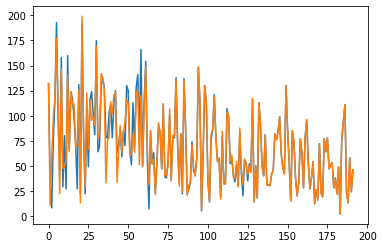

In [ ]:
plt.plot(in_data[64, 64, 30])
plt.plot(pred[64, 64, 30])

In [ ]:
out_data = moving_data[..., ~loo_idxer]
out_gtab = dpg.gradient_table(moving_bvals[~loo_idxer],
                                moving_bvecs[~loo_idxer])

out_pred = sff.predict(out_gtab, S0=ref_data[..., 0])


In [ ]:
out_data.shape, out_pred.shape

((128, 128, 60, 1), (128, 128, 60))

In [ ]:
foo = np.sqrt((out_data[:, :, 30, 0] - out_pred[:, :, 30])**2)

In [ ]:
foo.shape

(128, 128)

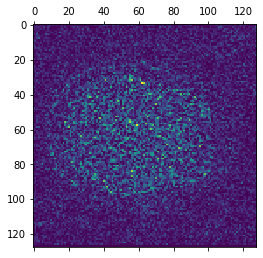

In [ ]:
plt.matshow(foo)

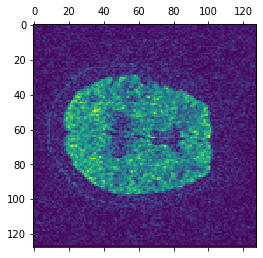

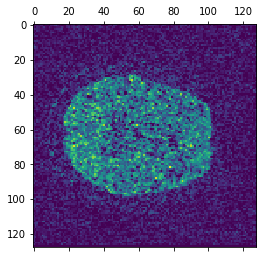

In [ ]:
plt.matshow(out_data[:, :, 30])
plt.matshow(out_pred[:, :, 30], vmin=0)

In [ ]:
np.max(out_data), np.max(out_pred), np.min(out_data), np.min(out_pred)

(702.0, 710.4306149988321, 0.0, -160.64181426074356)

In [ ]:
sfm.USV[1] < 10e-10

In [ ]:
def hmc(data, gtab, mask=None, b0_ref=0, affine=None):
    data, affine = read_img_arr_or_path(data, affine=affine)
    if isinstance(gtab, collections.Sequence):
        gtab = dpg.gradient_table(*gtab)

    # We fix b0 to be one volume, registered to one of the
    # b0 volumes (first, per default):
    if np.sum(gtab.b0s_mask) > 1:
        b0_img = nib.Nifti1Image(data[..., gtab.b0s_mask], affine)
        trans_b0, b0_affines = dpa.register_series(b0_img, ref=b0_ref)
        ref_data = np.mean(trans_b0, -1)[..., np.newaxis]
    else:
        # There's only one b0 and we register everything to it
        trans_b0 = ref_data = data[..., gtab.b0s_mask]

    moving_data = data[..., ~gtab.b0s_mask]
    moving_bvals = gtab.bvals[~gtab.b0s_mask]
    moving_bvecs = gtab.bvecs[~gtab.b0s_mask]
    mask = np.ones(ref_data.shape[:3])
    mask[np.where(ref_data[..., 0] == 0)] = 0
    moved = []
    affines = []
    for loo in range(moving_data.shape[-1]):
        print(loo)
        loo_idxer = np.ones(moving_data.shape[-1]).astype(bool)
        loo_idxer[loo] = False

        in_data = np.concatenate([ref_data, moving_data[..., loo_idxer]], -1)
        in_gtab = dpg.gradient_table(
            np.concatenate([np.array([0]), moving_bvals[loo_idxer]]),
            np.concatenate([np.array([[0, 0, 0]]), moving_bvecs[loo_idxer]]))

        sfm = SFM4HMC(
            in_gtab,
            isotropic=ExponentialIsotropicModel)

        sff = sfm.fit(in_data, mask=mask, frac=0.9)
        out_data = moving_data[..., ~loo_idxer]
        out_gtab = dpg.gradient_table(moving_bvals[~loo_idxer],
                                      moving_bvecs[~loo_idxer])

        out_pred = sff.predict(out_gtab, S0=ref_data[..., 0])

        resampled, starting_affine = dpa.affine_registration(
            out_data[..., 0],
            out_pred,
            moving_affine=affine,
            static_affine=affine,
            pipeline=[dpa.affine],
            level_iters=[10])

        moved.append(resampled)
        affines.append(starting_affine)
        in_data[..., loo] = resampled

# Reuse USV from a single SVD decomposition of X at the beginning of each
# loop through all of the volumes. Should speed up the RR fit in every volume.

# Use a sliding window to fit only to n nearest neighbors.

In [ ]:
hmc(data, gtab, mask=None, b0_ref=0, affine=img.affine)

NameError: name 'FRR4SFM' is not defined